In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

In [4]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\Apps\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [5]:
import os
os.getcwd()

'C:\\Users\\dsiri\\OneDrive\\Desktop\\BAN 5753\\Exercises'

In [7]:
from platform import python_version

print(python_version())

3.9.13


In [8]:
sc.version #spark version

'3.3.0'

## Read File

In [6]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("C:/Users/dsiri/OneDrive/Desktop/BAN 5753/Exercises/miniproject2/XYZ_Bank_Deposit_Data_Classification.csv")


### Sample Data

In [7]:
df.toPandas().head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### 1. Exploratory Data Analysis

In [8]:
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 41188 rows 21 columns in the data.


In [9]:
import re
cols =[re.sub("|\.","",i) for i in df.columns]
df= df.toDF(*cols)

In [11]:
df.groupby("y").count().show()

+---+-----+
|  y|count|
+---+-----+
| no|36548|
|yes| 4640|
+---+-----+



#### Data Types of Columns

In [12]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- empvarrate: double (nullable = true)
 |-- conspriceidx: double (nullable = true)
 |-- consconfidx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nremployed: double (nullable = true)
 |-- y: string (nullable = true)



#### Null Values

In [13]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [145]:
print("Numerical Variables")
df.toPandas().describe(include=['int','float'])

Numerical Variables


,age,duration,campaign,pdays,previous,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [146]:
print("Categorical Variables")
df.toPandas().describe(include=['object'])

Categorical Variables


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [147]:
#Cardinality of all variables
df.describe().toPandas().nunique()

summary         5
age             5
job             3
marital         3
education       3
default         3
housing         3
loan            3
contact         3
month           3
day_of_week     3
duration        5
campaign        5
pdays           5
previous        5
poutcome        3
empvarrate      5
conspriceidx    5
consconfidx     5
euribor3m       5
nremployed      5
y               3
dtype: int64

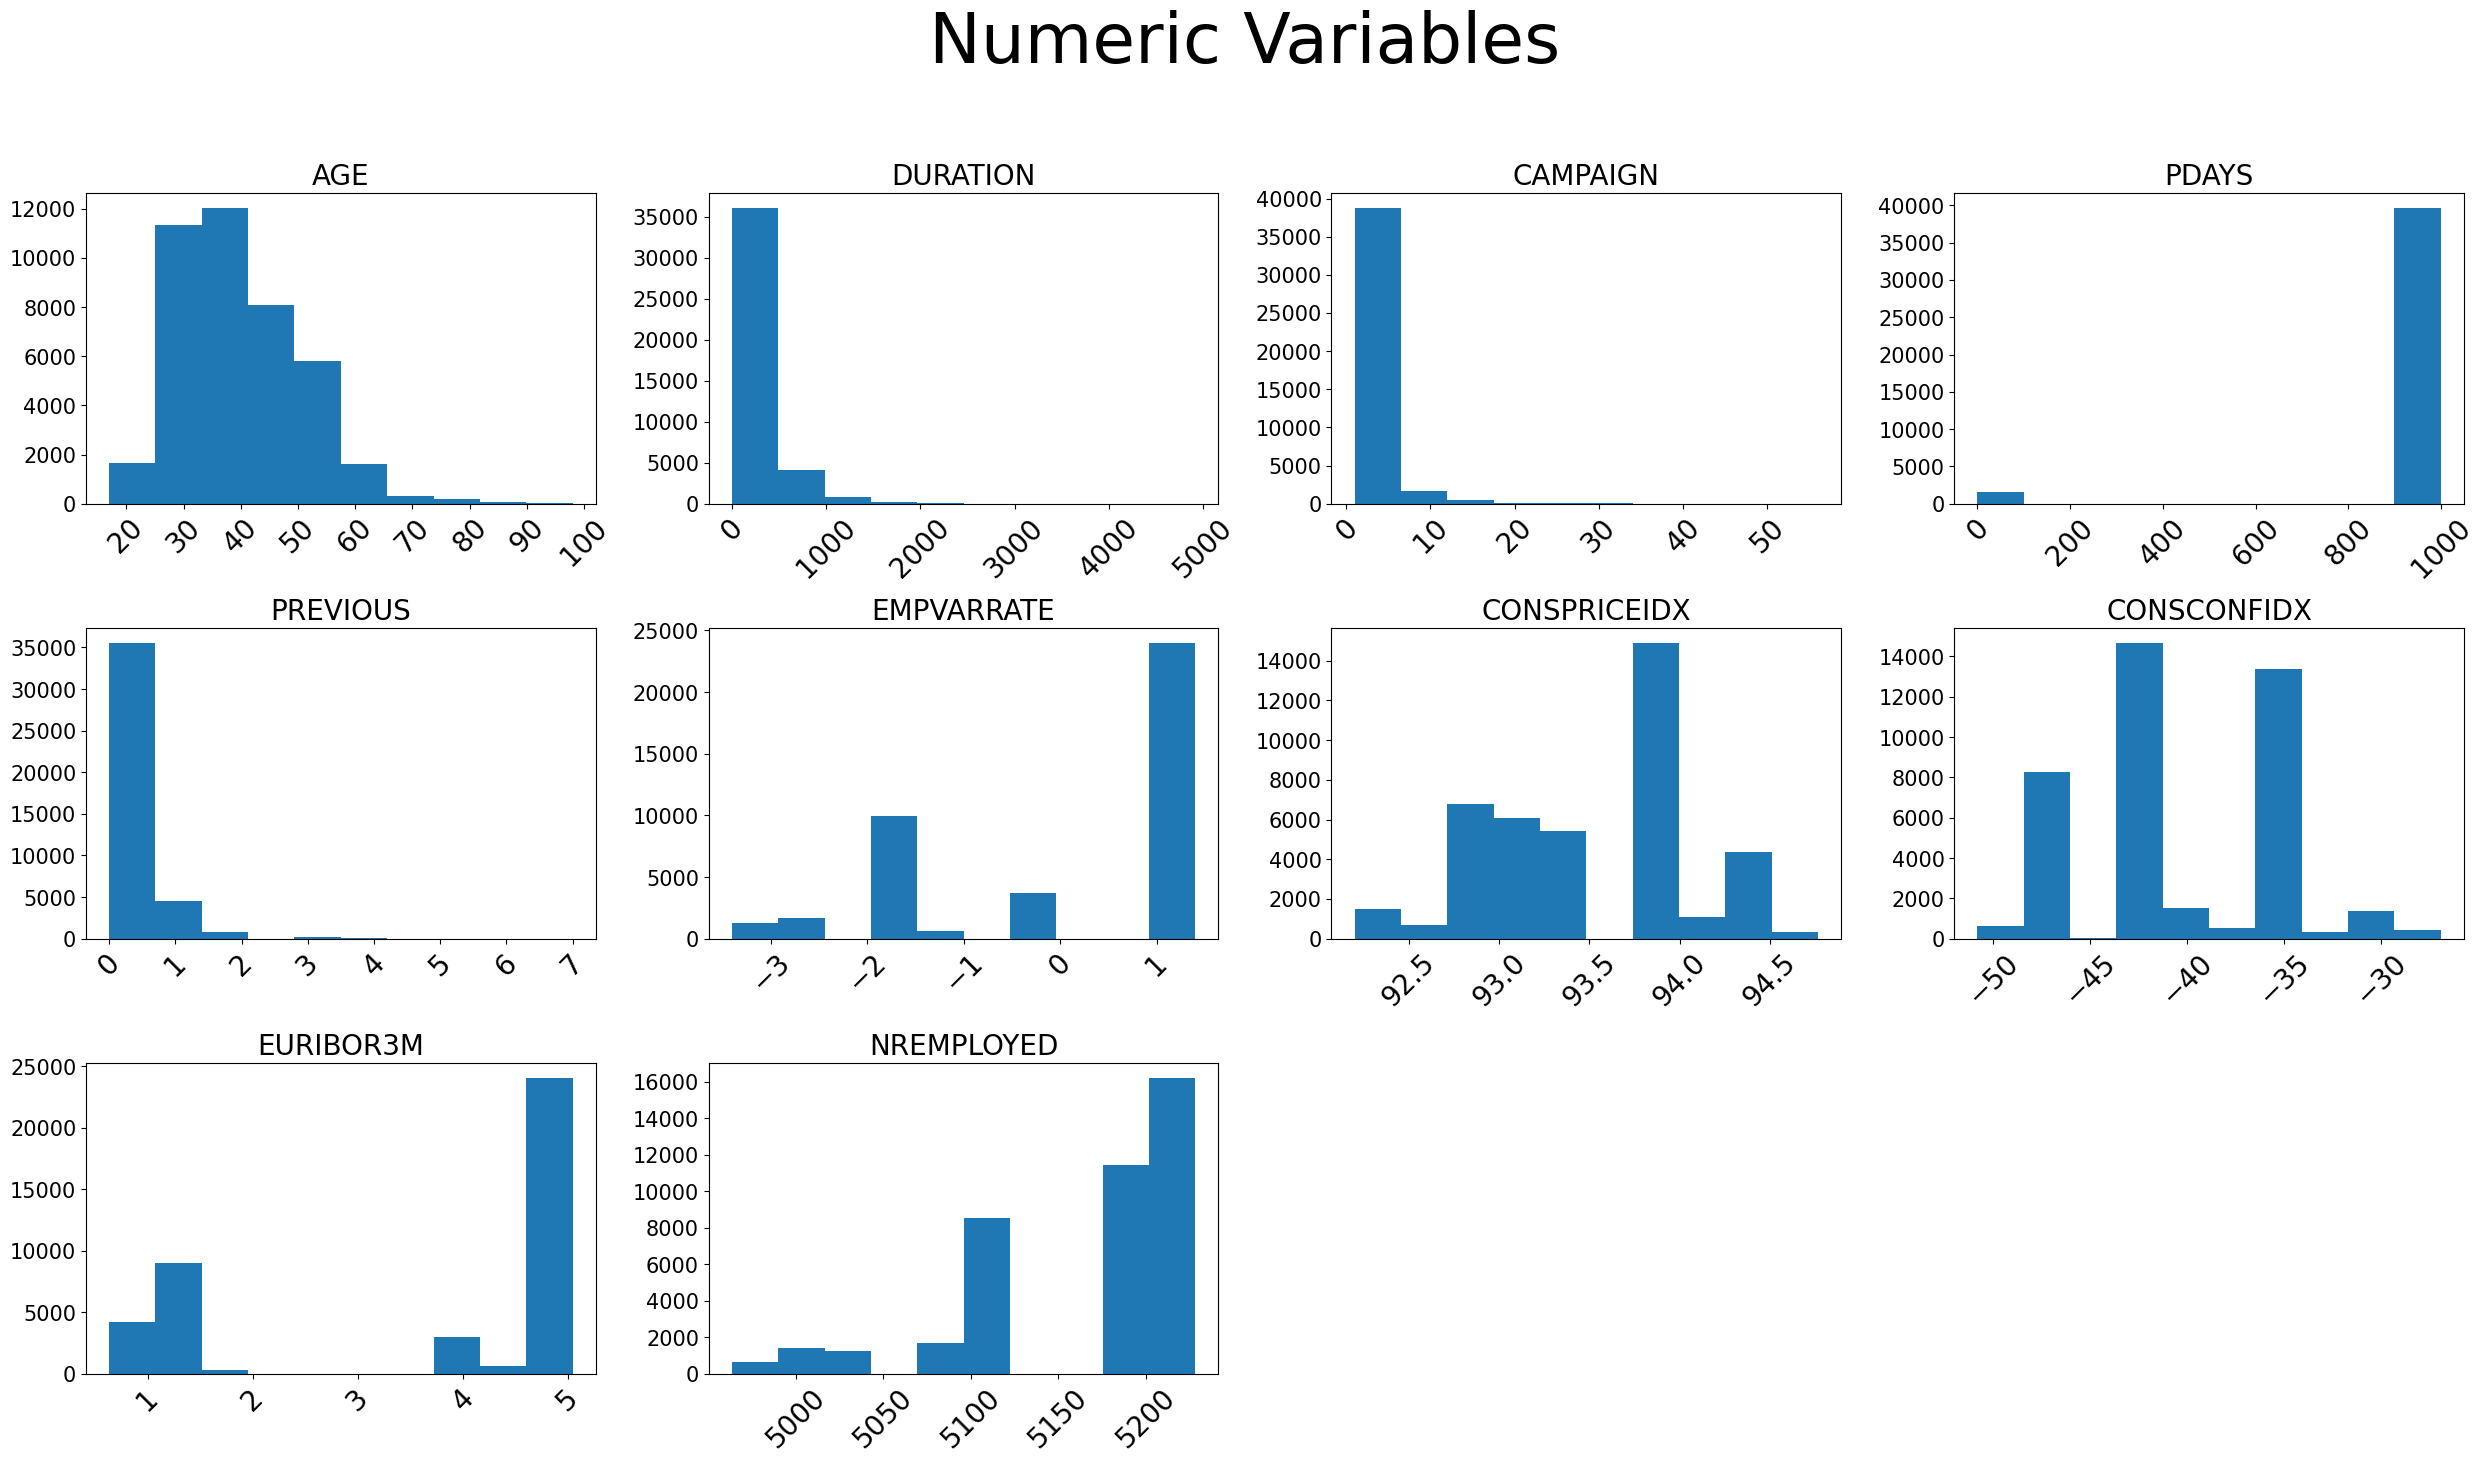

In [151]:
#Distribution of Features

from matplotlib import cm

fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Numeric Variables", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.style.use('fast') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

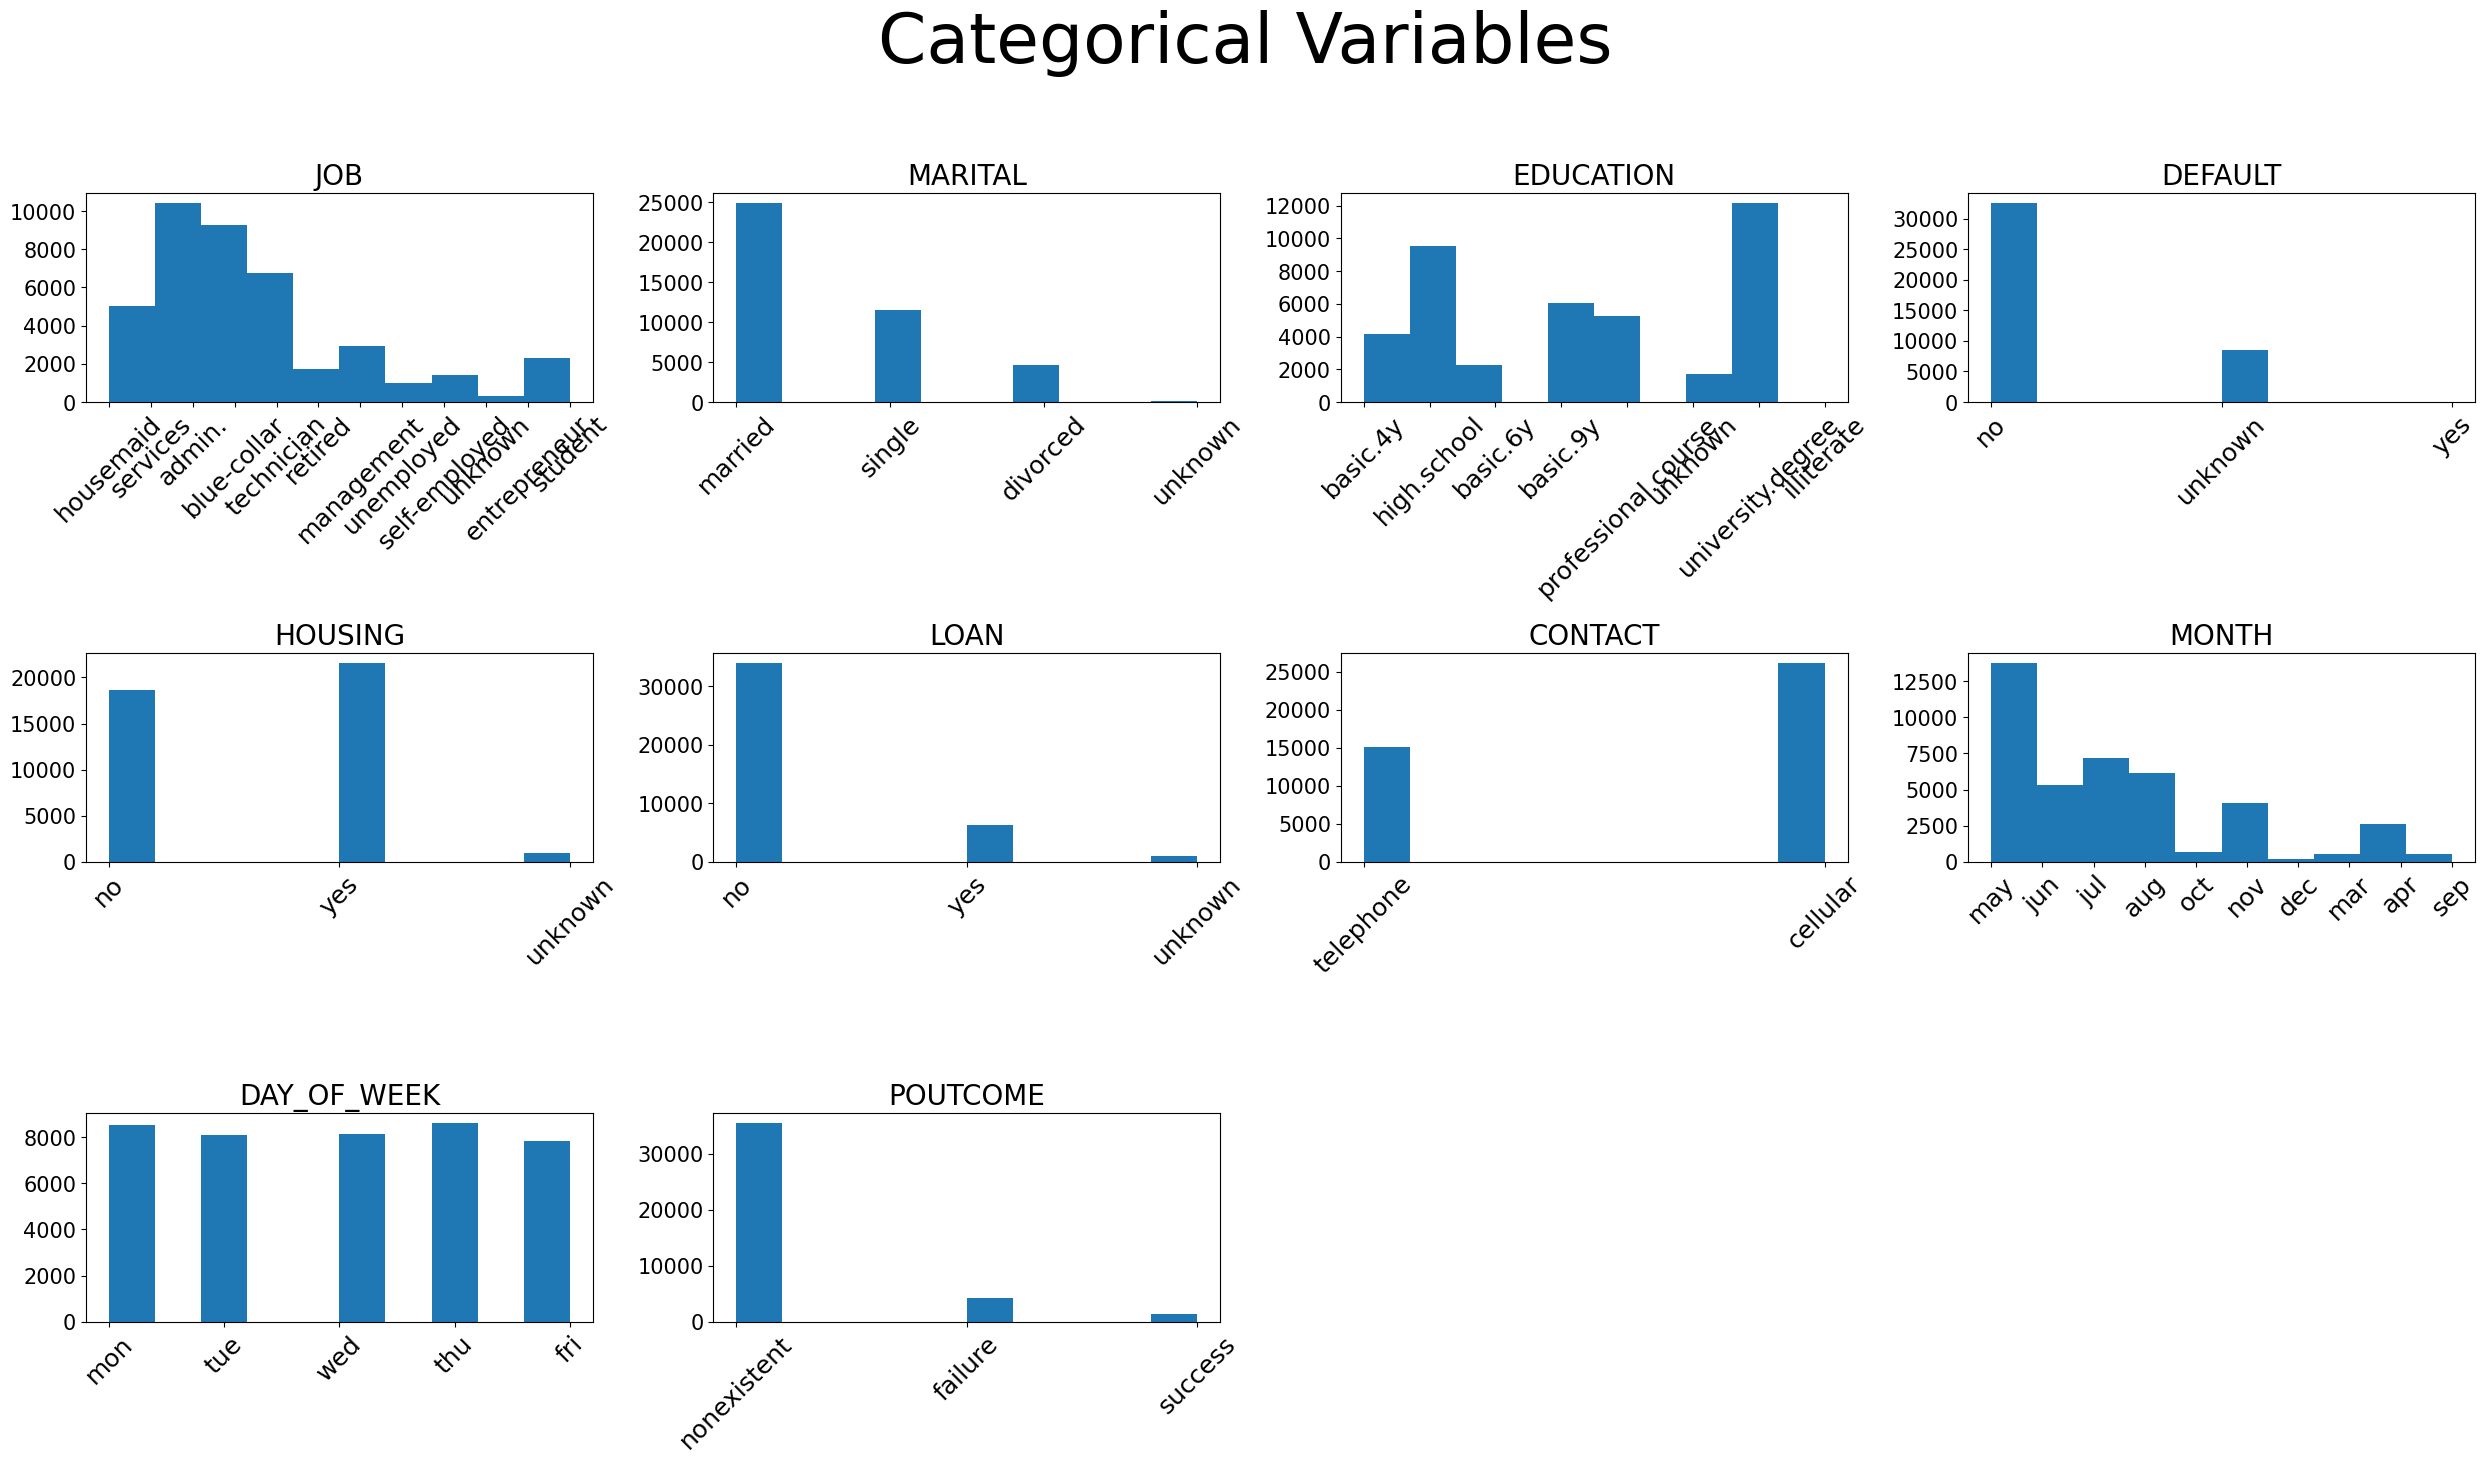

In [152]:
#Distribution of Features

from matplotlib import cm

fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Categorical Variables", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe(include=['object']).columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.style.use('fast') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=18)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 1.2)
plt.show()

In [154]:
#Pearson Correlation
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)

col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
corr_df


,age,duration,campaign,pdays,previous,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
empvarrate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
conspriceidx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
consconfidx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nremployed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


In [170]:
success = df.filter(df['y']=="yes").count()/ df.count() * 100
print("Marketing campaign success percent = "+ str(success))
Failure = df.filter(df['y']=="no").count()/ df.count() * 100
print("Marketing campaign failure percent = "+ str(Failure))

Marketing campaign success percent = 11.265417111780131
Marketing campaign failure percent = 88.73458288821988


<AxesSubplot:title={'center':' Meassure of Success rate'}, ylabel='y'>

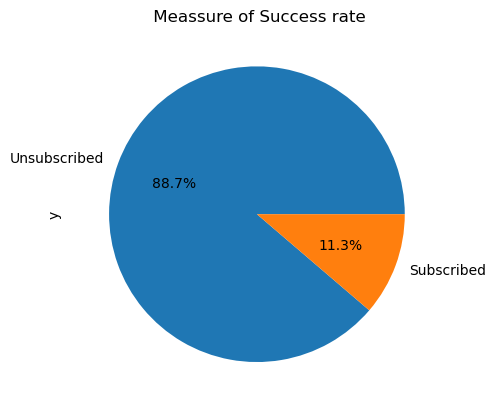

In [191]:
df1=df.toPandas()
piefreq=df1['y'].value_counts()
labels = ['Unsubscribed','Subscribed']
piefreq.plot.pie(autopct='%1.1f%%', labels=labels,title =' Meassure of Success rate')



In [177]:
df.filter(df['y']=="yes").groupBy("marital").count().orderBy('count', ascending=[False]).show()

+--------+-----+
| marital|count|
+--------+-----+
| married| 2532|
|  single| 1620|
|divorced|  476|
| unknown|   12|
+--------+-----+



<AxesSubplot:title={'center':'Marital status and deposit'}>

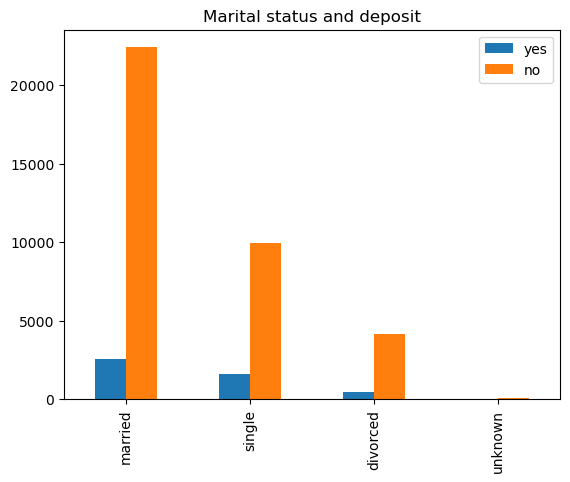

In [178]:
# marital status and deposit
j_df = pd.DataFrame()

j_df['yes'] = df1[df1['y'] == 'yes']['marital'].value_counts()
j_df['no'] = df1[df1['y'] == 'no']['marital'].value_counts()

j_df.plot.bar(title = 'Marital status and deposit')

In [179]:
#age and deposit
df.filter(df['y']=="yes").groupBy("age").count().orderBy('age').show(200)

+---+-----+
|age|count|
+---+-----+
| 17|    2|
| 18|   12|
| 19|   20|
| 20|   23|
| 21|   29|
| 22|   36|
| 23|   48|
| 24|   86|
| 25|   93|
| 26|  122|
| 27|  114|
| 28|  151|
| 29|  186|
| 30|  202|
| 31|  220|
| 32|  184|
| 33|  210|
| 34|  184|
| 35|  167|
| 36|  154|
| 37|  137|
| 38|  143|
| 39|  114|
| 40|   84|
| 41|  113|
| 42|   91|
| 43|   88|
| 44|   77|
| 45|   92|
| 46|   79|
| 47|   58|
| 48|   97|
| 49|   55|
| 50|   87|
| 51|   72|
| 52|   81|
| 53|   68|
| 54|   64|
| 55|   56|
| 56|   80|
| 57|   62|
| 58|   58|
| 59|   69|
| 60|   58|
| 61|   32|
| 62|   25|
| 63|   17|
| 64|   27|
| 65|   23|
| 66|   29|
| 67|   11|
| 68|   15|
| 69|   14|
| 70|   19|
| 71|   21|
| 72|   13|
| 73|   13|
| 74|   15|
| 75|   11|
| 76|   18|
| 77|   13|
| 78|   14|
| 79|    7|
| 80|   18|
| 81|    8|
| 82|   11|
| 83|    8|
| 84|    3|
| 85|    7|
| 86|    5|
| 87|    1|
| 88|    9|
| 89|    2|
| 92|    3|
| 98|    2|
+---+-----+



In [180]:
#job and deposit
df.filter(df['y']=="yes").groupBy("job").count().orderBy('count', ascending=[False]).show(200)

+-------------+-----+
|          job|count|
+-------------+-----+
|       admin.| 1352|
|   technician|  730|
|  blue-collar|  638|
|      retired|  434|
|   management|  328|
|     services|  323|
|      student|  275|
|self-employed|  149|
|   unemployed|  144|
| entrepreneur|  124|
|    housemaid|  106|
|      unknown|   37|
+-------------+-----+



<AxesSubplot:title={'center':'Job and deposit'}>

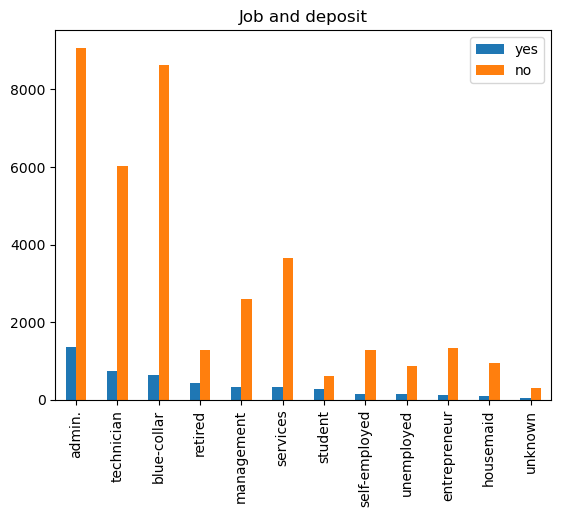

In [181]:
#job and deposit
df1=df.toPandas()

j_df = pd.DataFrame()

j_df['yes'] = df1[df1['y'] == 'yes']['job'].value_counts()
j_df['no'] = df1[df1['y'] == 'no']['job'].value_counts()

j_df.plot.bar(title = 'Job and deposit')

In [182]:
#education and deposit
df.filter(df['y']=="yes").groupBy("education").count().orderBy('count', ascending=[False]).show(200)

+-------------------+-----+
|          education|count|
+-------------------+-----+
|  university.degree| 1670|
|        high.school| 1031|
|professional.course|  595|
|           basic.9y|  473|
|           basic.4y|  428|
|            unknown|  251|
|           basic.6y|  188|
|         illiterate|    4|
+-------------------+-----+



<AxesSubplot:title={'center':'Education and deposit'}>

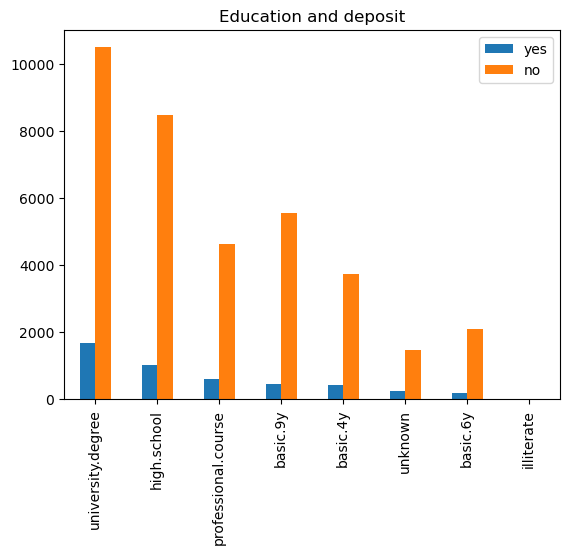

In [183]:
df1=df.toPandas()
#education and deposit
j_df = pd.DataFrame()

j_df['yes'] = df1[df1['y'] == 'yes']['education'].value_counts()
j_df['no'] = df1[df1['y'] == 'no']['education'].value_counts()

j_df.plot.bar(title = 'Education and deposit')

In [184]:
#Contact and deposit
df.filter(df['y']=="yes").groupBy("contact").count().orderBy('count', ascending=[False]).show(200)

+---------+-----+
|  contact|count|
+---------+-----+
| cellular| 3853|
|telephone|  787|
+---------+-----+



In [19]:
#Create a new column - Age Group
df2=df
def udf_multiple(age):
      if (age <= 25):
        return 'Under 25'
      elif (age >= 25 and age <= 35):
        return 'Between 25 and 35'
      elif (age > 35 and age < 50):
        return 'Between 36 and 49'
      elif (age >= 50):
        return 'Over 50'
      else: return 'N/A'

age_udf = udf(udf_multiple)
df2=df2.withColumn("age_group", age_udf('age'))


<AxesSubplot:title={'center':'Type of contact and deposit'}>

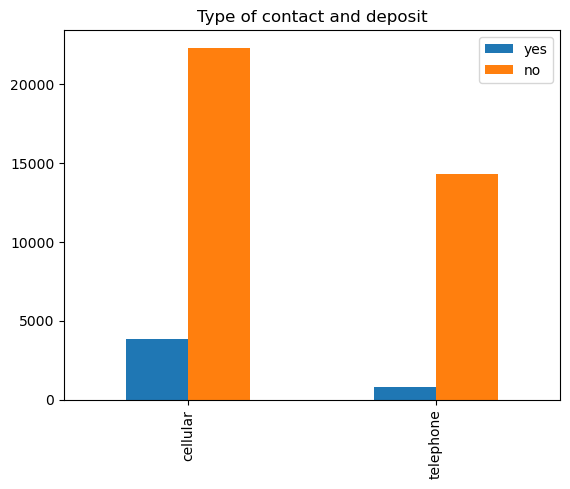

In [185]:
#type of contact and deposit
j_df = pd.DataFrame()

j_df['yes'] = df1[df1['y'] == 'yes']['contact'].value_counts()
j_df['no'] = df1[df1['y'] == 'no']['contact'].value_counts()

j_df.plot.bar(title = 'Type of contact and deposit')

KeyError: 'y'

In [20]:
#Create a new column - pdays_contact

def udf_pdays(pdays):
      if (pdays == 999):
        return '0'
      else: return '1'

pdays_udf = udf(udf_pdays)
df2=df2.withColumn("pdays_contact", pdays_udf('pdays'))


In [31]:
df2=df2.drop("age","pdays")
df2.printSchema()
df2.toPandas().head(5)

root
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- empvarrate: double (nullable = true)
 |-- conspriceidx: double (nullable = true)
 |-- consconfidx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nremployed: double (nullable = true)
 |-- y: string (nullable = true)
 |-- age_group: string (nullable = true)
 |-- pdays_contact: string (nullable = true)



,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,...,previous,poutcome,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y,age_group,pdays_contact
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 50,0
1,services,married,high.school,unknown,no,no,telephone,may,mon,149,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 50,0
2,services,married,high.school,no,yes,no,telephone,may,mon,226,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Between 36 and 49,0
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Between 36 and 49,0
4,services,married,high.school,no,no,yes,telephone,may,mon,307,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 50,0


In [99]:
df3=df2

job_indexer = StringIndexer(inputCol="job", outputCol="job_index")
marital_indexer = StringIndexer(inputCol="marital", outputCol="marital_index")
education_indexer = StringIndexer(inputCol="education", outputCol="education_index")
default_indexer = StringIndexer(inputCol="default", outputCol="default_index")
housing_indexer = StringIndexer(inputCol="housing", outputCol="housing_index")
loan_indexer = StringIndexer(inputCol="loan", outputCol="loan_index")
contact_indexer = StringIndexer(inputCol="contact", outputCol="contact_index")
month_indexer = StringIndexer(inputCol="month", outputCol="month_index")
day_of_week_indexer = StringIndexer(inputCol="day_of_week", outputCol="day_of_week_index")
poutcome_indexer = StringIndexer(inputCol="poutcome", outputCol="poutcome_index")
y_indexer = StringIndexer(inputCol="y", outputCol="label")
age_indexer = StringIndexer(inputCol="age_group", outputCol="age_group_index")
pdays_contact_indexer = StringIndexer(inputCol="pdays_contact", outputCol="pdays_contact_index")

pipeline = Pipeline(stages=[job_indexer, marital_indexer,education_indexer,default_indexer,housing_indexer,loan_indexer,contact_indexer,month_indexer,day_of_week_indexer, poutcome_indexer,y_indexer, age_indexer,pdays_contact_indexer])
index_df = pipeline.fit(df2).transform(df2)
index_df.toPandas().tail(10)

,job,marital,education,default,housing,loan,...,month_index,day_of_week_index,poutcome_index,label,age_group_index,pdays_contact_index
41178,retired,married,university.degree,no,no,no,...,4.0,0.0,2.0,1.0,2.0,1.0
41179,retired,divorced,professional.course,no,yes,no,...,4.0,4.0,0.0,0.0,2.0,0.0
41180,admin.,married,university.degree,no,no,no,...,4.0,4.0,0.0,0.0,0.0,0.0
41181,admin.,married,university.degree,no,yes,no,...,4.0,4.0,0.0,1.0,0.0,0.0
41182,unemployed,single,basic.4y,no,yes,no,...,4.0,4.0,2.0,0.0,1.0,1.0
41183,retired,married,professional.course,no,yes,no,...,4.0,4.0,0.0,1.0,2.0,0.0
41184,blue-collar,married,professional.course,no,no,no,...,4.0,4.0,0.0,0.0,0.0,0.0
41185,retired,married,university.degree,no,yes,no,...,4.0,4.0,0.0,0.0,2.0,0.0
41186,technician,married,professional.course,no,no,no,...,4.0,4.0,0.0,1.0,0.0,0.0
41187,retired,married,professional.course,no,yes,no,...,4.0,4.0,1.0,0.0,2.0,0.0


In [100]:
## One-hot encoder


job_encoder = OneHotEncoder(inputCol="job_index", outputCol="job_encoded")
marital_encoder = OneHotEncoder(inputCol="marital_index", outputCol="marital_encoded")
education_encoder = OneHotEncoder(inputCol="education_index", outputCol="education_encoded")
default_encoder = OneHotEncoder(inputCol="default_index", outputCol="default_encoded")
housing_encoder = OneHotEncoder(inputCol="housing_index", outputCol="housing_encoded")
loan_encoder = OneHotEncoder(inputCol="loan_index", outputCol= "loan_encoded")
contact_encoder = OneHotEncoder(inputCol="contact_index", outputCol= "contact_encoded")
month_encoder = OneHotEncoder(inputCol="month_index", outputCol= "month_encoded")
day_of_week_encoder = OneHotEncoder(inputCol="day_of_week_index", outputCol= "day_of_week_encoded")
poutcome_encoder = OneHotEncoder(inputCol="poutcome_index", outputCol= "poutcome_encoded")
y_encoder = OneHotEncoder(inputCol="label", outputCol= "y_encoded")
age_encoder = OneHotEncoder(inputCol="age_group_index", outputCol= "age_encoded")
pdays_encoder = OneHotEncoder(inputCol="pdays_contact_index", outputCol= "pdays_encoded")

pipeline = Pipeline(stages=[job_encoder,marital_encoder,education_encoder,default_encoder,housing_encoder,\
                            loan_encoder,contact_encoder,month_encoder,day_of_week_encoder,\
                            poutcome_encoder,y_encoder,age_encoder,pdays_encoder ])
encoder_model = pipeline.fit(index_df).transform(index_df)
encoder_model.toPandas().head(10)

,job,marital,education,default,housing,loan,...,month_encoded,day_of_week_encoded,poutcome_encoded,y_encoded,age_encoded,pdays_encoded
0,housemaid,married,basic.4y,no,no,no,...,"(1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, ...","(1.0, 0.0)",(1.0),"(0.0, 0.0, 1.0)",(1.0)
1,services,married,high.school,unknown,no,no,...,"(1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, ...","(1.0, 0.0)",(1.0),"(0.0, 0.0, 1.0)",(1.0)
2,services,married,high.school,no,yes,no,...,"(1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, ...","(1.0, 0.0)",(1.0),"(1.0, 0.0, 0.0)",(1.0)
3,admin.,married,basic.6y,no,no,no,...,"(1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, ...","(1.0, 0.0)",(1.0),"(1.0, 0.0, 0.0)",(1.0)
4,services,married,high.school,no,no,yes,...,"(1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, ...","(1.0, 0.0)",(1.0),"(0.0, 0.0, 1.0)",(1.0)
5,services,married,basic.9y,unknown,no,no,...,"(1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, ...","(1.0, 0.0)",(1.0),"(1.0, 0.0, 0.0)",(1.0)
6,admin.,married,professional.course,no,no,no,...,"(1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, ...","(1.0, 0.0)",(1.0),"(0.0, 0.0, 1.0)",(1.0)
7,blue-collar,married,unknown,unknown,no,no,...,"(1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, ...","(1.0, 0.0)",(1.0),"(1.0, 0.0, 0.0)",(1.0)
8,technician,single,professional.course,no,yes,no,...,"(1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, ...","(1.0, 0.0)",(1.0),"(0.0, 0.0, 0.0)",(1.0)
9,services,single,high.school,no,yes,no,...,"(1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, ...","(1.0, 0.0)",(1.0),"(0.0, 0.0, 0.0)",(1.0)


In [101]:
encoder_model.printSchema()

root
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- empvarrate: double (nullable = true)
 |-- conspriceidx: double (nullable = true)
 |-- consconfidx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nremployed: double (nullable = true)
 |-- y: string (nullable = true)
 |-- age_group: string (nullable = true)
 |-- pdays_contact: string (nullable = true)
 |-- job_index: double (nullable = false)
 |-- marital_index: double (nullable = false)
 |-- education_index: double (nullable = false)
 |-- default_inde

In [102]:

## Vector assembler

import pandas as pd
pd.set_option('display.max_colwidth', 80)
pd.set_option("display.max_columns", 12)

assembler = VectorAssembler()\
         .setInputCols (["age_encoded","job_encoded","marital_encoded","education_encoded",
                         "default_encoded","housing_encoded","loan_encoded","contact_encoded",\
                         "month_encoded","day_of_week_encoded","duration",\
                         "campaign","previous","poutcome_encoded",\
                         "empvarrate", "conspriceidx","consconfidx","euribor3m","nremployed","pdays_encoded"])\
         .setOutputCol ("vectorized_features")
        
# In case of missing you can skip the invalid ones
assembler_df=assembler.setHandleInvalid("skip").transform(encoder_model)
assembler_df.toPandas().head()

,job,marital,education,default,housing,loan,...,day_of_week_encoded,poutcome_encoded,y_encoded,age_encoded,pdays_encoded,vectorized_features
0,housemaid,married,basic.4y,no,no,no,...,"(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)",(1.0),"(0.0, 0.0, 1.0)",(1.0),"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
1,services,married,high.school,unknown,no,no,...,"(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)",(1.0),"(0.0, 0.0, 1.0)",(1.0),"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
2,services,married,high.school,no,yes,no,...,"(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)",(1.0),"(1.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
3,admin.,married,basic.6y,no,no,no,...,"(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)",(1.0),"(1.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
4,services,married,high.school,no,no,yes,...,"(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)",(1.0),"(0.0, 0.0, 1.0)",(1.0),"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [164]:
## Standard Scaler

scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")
        
scaler_model=scaler.fit(assembler_df)
scaler_df=scaler_model.transform(assembler_df)
scaler_df.select("vectorized_features","features").toPandas().head(5)


,features
0,"(0.0, 0.0, 2.521170862475759, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.3152..."
1,"(0.0, 0.0, 2.521170862475759, 0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, 0..."
2,"(2.0382855256725416, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, ..."
3,"(2.0382855256725416, 0.0, 0.0, 2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
4,"(0.0, 0.0, 2.521170862475759, 0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, 0..."


In [104]:
# weighted col since the target variable is unbalanced
balancingRatio = scaler_df.filter(col('label') == 1).count() / scaler_df.count()
calculateWeights = udf(lambda x: 1 * balancingRatio if x == 0 else (1 * (1.0 - balancingRatio)), DoubleType())

weightedDataset = scaler_df.withColumn("classWeightCol", calculateWeights('label'))

weightedDataset.toPandas().head(10)

,job,marital,education,default,housing,loan,...,y_encoded,age_encoded,pdays_encoded,vectorized_features,features,classWeightCol
0,housemaid,married,basic.4y,no,no,no,...,(1.0),"(0.0, 0.0, 1.0)",(1.0),"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 2.521170862475759, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.3152...",0.112654
1,services,married,high.school,unknown,no,no,...,(1.0),"(0.0, 0.0, 1.0)",(1.0),"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 2.521170862475759, 0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, 0...",0.112654
2,services,married,high.school,no,yes,no,...,(1.0),"(1.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(2.0382855256725416, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, ...",0.112654
3,admin.,married,basic.6y,no,no,no,...,(1.0),"(1.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(2.0382855256725416, 0.0, 0.0, 2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",0.112654
4,services,married,high.school,no,no,yes,...,(1.0),"(0.0, 0.0, 1.0)",(1.0),"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 2.521170862475759, 0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, 0...",0.112654
5,services,married,basic.9y,unknown,no,no,...,(1.0),"(1.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(2.0382855256725416, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, ...",0.112654
6,admin.,married,professional.course,no,no,no,...,(1.0),"(0.0, 0.0, 1.0)",(1.0),"(0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 2.521170862475759, 2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",0.112654
7,blue-collar,married,unknown,unknown,no,no,...,(1.0),"(1.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(2.0382855256725416, 0.0, 0.0, 0.0, 2.3959294394012933, 0.0, 0.0, 0.0, 0.0, ...",0.112654
8,technician,single,professional.course,no,yes,no,...,(1.0),"(0.0, 0.0, 0.0)",(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 2.702562569704294, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",0.112654
9,services,single,high.school,no,yes,no,...,(1.0),"(0.0, 0.0, 0.0)",(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.112654


In [106]:
train, test = weightedDataset.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32894
Test Dataset Count: 8294


In [107]:
train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|29215|
|  1.0| 3679|
+-----+-----+



In [ ]:
## Logistic Regression Model

In [201]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', weightCol="classWeightCol",maxIter=5)
lrModel = lr.fit(train)
import os, tempfile

path = "C:/Users/dsiri/OneDrive/Desktop/BAN 5753/Exercises/miniproject2/LRFinal"
lrModel.saveAsPickleFile(path)
predictions = lrModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

AttributeError: 'LogisticRegressionModel' object has no attribute 'saveAsPickleFile'

In [ ]:
## Logistic Regression Model- Evaluation

In [132]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("LR Model Accuracy : ",accuracy)

LR Model Accuracy :  0.857125632987702


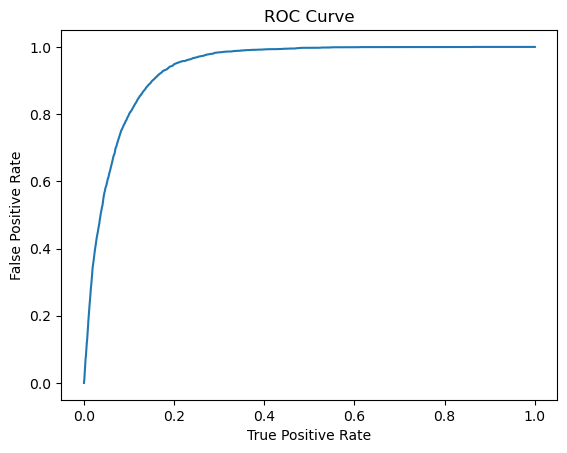

Training set areaUnderROC: 0.9373827716337794


In [144]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [134]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9323048644865595


In [135]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 840  121]
 [1064 6269]]


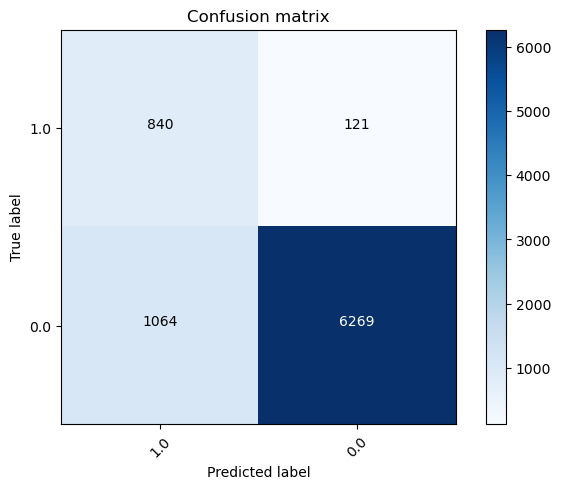

In [136]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [155]:
#Best Model Feature Weights
weights = lrModel.coefficients
weights = [(float(w),) for w in weights]
weightsDF = sqlContext.createDataFrame(weights, ["Feature Weight"])
weightsDF.toPandas()

,Feature Weight
0,-0.067918
1,-0.025688
2,0.035360
3,-0.000296
4,-0.076350
5,0.003294
6,-0.025547
7,-0.011254
8,0.075083
9,-0.010785


In [ ]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [ ]:
## Decision Tree Model

In [113]:

from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label',weightCol="classWeightCol", maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+--------------------+----------+--------------------+
|label|            features|       rawPrediction|prediction|         probability|
+-----+--------------------+--------------------+----------+--------------------+
|  1.0|(55,[2,3,16,21,25...|[284.902398756919...|       1.0|[0.18590565860059...|
|  0.0|(55,[2,3,16,22,24...|[949.111391667475...|       0.0|[0.73431407679258...|
|  0.0|(55,[2,3,16,22,25...|[1810.46518403427...|       0.0|[0.92686190516509...|
|  0.0|(55,[2,3,16,22,25...|[949.111391667475...|       0.0|[0.73431407679258...|
|  0.0|(55,[2,3,16,19,24...|[1810.46518403427...|       0.0|[0.92686190516509...|
|  0.0|(55,[1,3,16,19,24...|[284.902398756919...|       1.0|[0.18590565860059...|
|  0.0|(55,[0,3,16,19,24...|[949.111391667475...|       0.0|[0.73431407679258...|
|  0.0|(55,[0,3,16,19,24...|[1810.46518403427...|       0.0|[0.92686190516509...|
|  0.0|(55,[0,3,16,19,24...|[949.111391667475...|       0.0|[0.73431407679258...|
|  0.0|(55,[2,3,

In [ ]:
## Decision Tree Model Evaluation

In [114]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("DT Model Accuracy : ",accuracy)

DT Model Accuracy :  0.8472389679286231


In [116]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.833194858587603


In [ ]:
## Random Forest Model 

In [167]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', weightCol="classWeightCol")
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+--------------------+----------+--------------------+
|label|            features|       rawPrediction|prediction|         probability|
+-----+--------------------+--------------------+----------+--------------------+
|  1.0|(55,[2,3,16,21,25...|[10.1535275353266...|       0.0|[0.50767637676633...|
|  0.0|(55,[2,3,16,22,24...|[15.6269783594543...|       0.0|[0.78134891797271...|
|  0.0|(55,[2,3,16,22,25...|[16.4974760627659...|       0.0|[0.82487380313829...|
|  0.0|(55,[2,3,16,22,25...|[15.3695800461629...|       0.0|[0.76847900230814...|
|  0.0|(55,[2,3,16,19,24...|[16.6608749778921...|       0.0|[0.83304374889460...|
|  0.0|(55,[1,3,16,19,24...|[8.8944429143064,...|       1.0|[0.44472214571532...|
|  0.0|(55,[0,3,16,19,24...|[14.6172101831858...|       0.0|[0.73086050915929...|
|  0.0|(55,[0,3,16,19,24...|[17.7414833631662...|       0.0|[0.88707416815831...|
|  0.0|(55,[0,3,16,19,24...|[17.0187176517615...|       0.0|[0.85093588258807...|
|  0.0|(55,[2,3,

In [168]:
rfModel.featureImportances

SparseVector(55, {0: 0.0012, 1: 0.0001, 2: 0.0015, 3: 0.0002, 4: 0.0045, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0008, 9: 0.0001, 10: 0.0002, 11: 0.0001, 12: 0.0, 13: 0.0005, 14: 0.0001, 15: 0.0001, 16: 0.0, 17: 0.0001, 18: 0.0001, 19: 0.0003, 20: 0.0001, 22: 0.0, 23: 0.0003, 24: 0.0064, 25: 0.0038, 26: 0.0001, 27: 0.0001, 29: 0.0, 30: 0.0145, 31: 0.0079, 32: 0.0004, 33: 0.0004, 34: 0.0001, 35: 0.0001, 36: 0.0112, 37: 0.0019, 38: 0.0018, 39: 0.0073, 40: 0.0003, 41: 0.0002, 43: 0.0001, 44: 0.3626, 45: 0.0011, 46: 0.0424, 47: 0.0013, 48: 0.0045, 49: 0.1539, 50: 0.0296, 51: 0.0314, 52: 0.0944, 53: 0.1947, 54: 0.0167})

In [ ]:
## Random Forest Model Evaluation

In [118]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("RF Model Accuracy : ",accuracy)

RF Model Accuracy :  0.7991319025801784


In [119]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9141143914449995


Confusion matrix, without normalization
[[ 181  780]
 [  51 7282]]


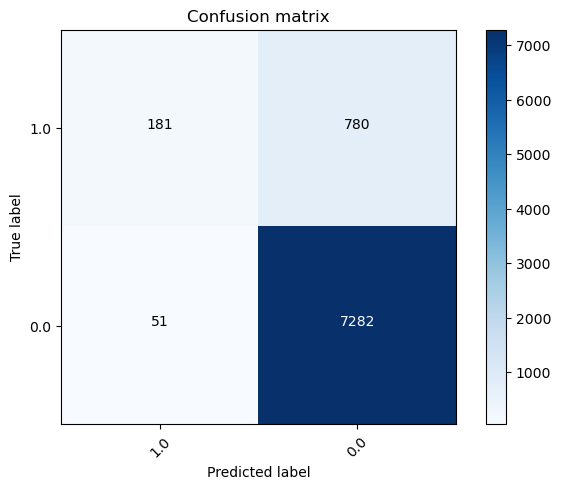

In [80]:
y_true = predictions.select("y_index")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [ ]:
## k-Means Model

In [122]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(train)
    
    KMeans_transform=KMeans_fit.transform(train)
    
    
    
    score=evaluator.evaluate(KMeans_transform)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)


Silhouette Score: 0.20564034736727588
Silhouette Score: 0.15431676931297755
Silhouette Score: 0.11369099993613313
Silhouette Score: 0.08234904615963454
Silhouette Score: 0.09115888106088038
Silhouette Score: 0.07828634906447443
Silhouette Score: 0.13855626480629873
Silhouette Score: 0.08628469651290839


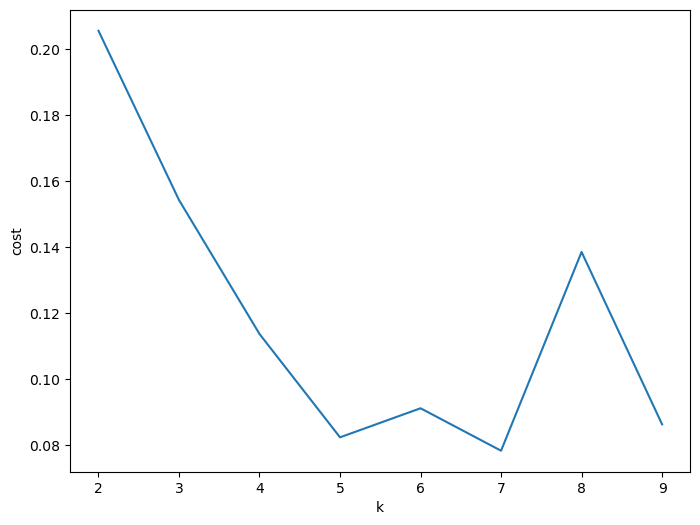

In [123]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.show()

In [126]:
KMeans_=KMeans(featuresCol='features', k=2) 
KMeans_Model=KMeans_.fit(train)
predictions=KMeans_Model.transform(test)

predictions.show(10)



+------+--------+---------+-------+-------+----+---------+-----+-----------+--------+--------+--------+-----------+----------+------------+-----------+---------+----------+---+-----------------+-------------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+-----+---------------+-------------------+--------------+---------------+-----------------+---------------+---------------+-------------+---------------+-------------+-------------------+----------------+-------------+-------------+-------------+--------------------+--------------------+-------------------+----------+
|   job| marital|education|default|housing|loan|  contact|month|day_of_week|duration|campaign|previous|   poutcome|empvarrate|conspriceidx|consconfidx|euribor3m|nremployed|  y|        age_group|pdays_contact|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|pou

In [ ]:
## kMeans Model Evaluation

In [127]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("kMeans Model Accuracy : ",accuracy)

kMeans Model Accuracy :  0.699180130214613


Confusion matrix, without normalization
[[ 3328  1312]
 [10904 25644]]


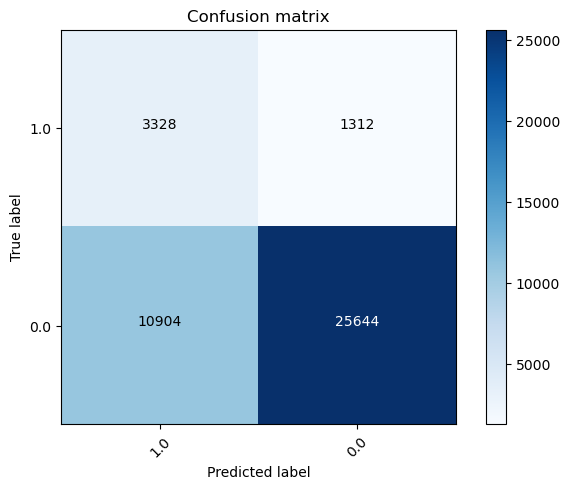

In [87]:
y_true = KMeans_Assignments.select("label")
y_true = y_true.toPandas()

y_pred = KMeans_Assignments.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [88]:
accuracy = KMeans_Assignments.filter(KMeans_Assignments.y_index == KMeans_Assignments.prediction).count() / float(KMeans_Assignments.count())
print("Accuracy : ",accuracy)

Accuracy :  0.703408759832961


In [83]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(scaler_df)
pca_transformed = pca_model.transform(scaler_df)
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

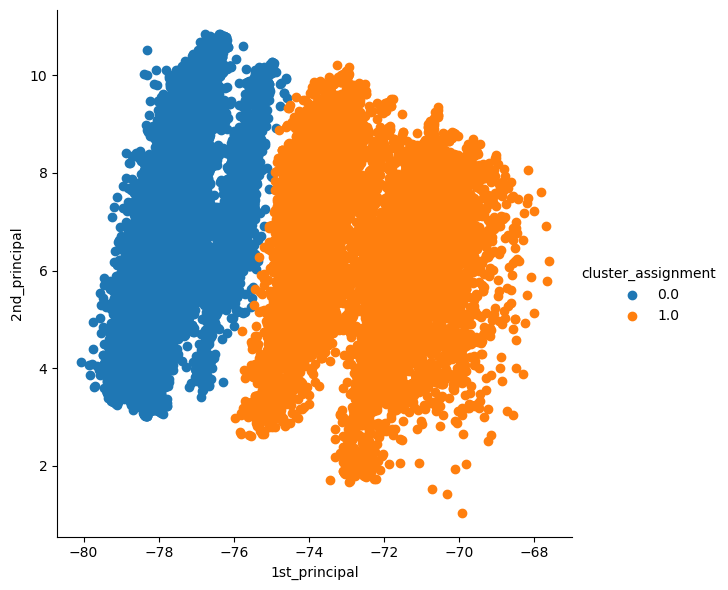

In [84]:
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()